# Data description & Problem statement: 
   The IMDB movie reviews dataset is a set of 50,000 reviews, half of which are positive and the other half negative. This dataset is widely used in sentiment analysis benchmarks, which makes it a convenient way to evaluate our own performance against existing models. The dataset is available online and can be either directly downloaded from Stanford’s website. 

# Workflow:
- Load the training and test datasets
- Data cleaning (e.g. remove formats and punctuations)
- Text vectorization, using "Bag of Words" technique
- Use "tf-idf transformation", and find the "N-grams" to improve the model performace
- Use a supervised classifier (e.g. Logistic Regression, Naive Bayes, etc.) for text classification: Use Grid-Serach along with Cross-Validation technique for finding the optimal hyper-parameters of best classifier
- Evaluate the performance of best classifier on the test data set, by calculating:
     - Accuracy
     - f1, Precision, Recall scores
     - Confusion matrix
     - ROC curve  
- Finally, determine most important words/features during semantic analysis for both positive and negative reviews


   * Note: I repeat abovementioned process with and without Word Normalization (i.e. using lammatization/stemming) for the sake of comparison. For the word normalization I use "SpaCy" library.

In [1]:
import sklearn
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# we insatll and import spacy package for some advanced tokenizaion techniques:
import spacy

# we also install and import mglearn package (using !pip install mglearn) for some interesting visualization of results:
import mglearn

In [2]:
!tree aclImdb

Folder PATH listing for volume OS
Volume serial number is 3EA9-93A4
C:\USERS\RHASH\DOCUMENTS\DATASETS\NLP PROJECTS (SKLEARN & SPARK)\ACLIMDB
ÃÄÄÄtest
³   ÃÄÄÄneg
³   ÀÄÄÄpos
ÃÄÄÄtrain
³   ÃÄÄÄneg
³   ÀÄÄÄpos
ÀÄÄÄunsupervised
    ÀÄÄÄunsup


# load and prepare the text data: 

In [3]:
# load the training data:
from sklearn.datasets import load_files
reviews_train = load_files("aclImdb/train/") # load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target 

print("type of text_train: {}".format(type(text_train)), "\n") 
print("length of text_train: {}".format(len(text_train)), "\n") 
print("Samples per class (training): {}".format(np.bincount(y_train)), "\n") 

print("text_train[0]:\n{}".format(text_train[0]))

type of text_train: <class 'list'> 

length of text_train: 25000 

Samples per class (training): [12500 12500] 

text_train[0]:
b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."


In [4]:
# load the test data too:
reviews_test = load_files("aclImdb/test/") 
text_test, y_test = reviews_test.data, reviews_test.target 
print("Number of documents in test data: {}".format(len(text_test))) 
print("Samples per class (test): {}".format(np.bincount(y_test))) 

Number of documents in test data: 25000
Samples per class (test): [12500 12500]


In [5]:
# text_train contains some HTML line breaks (<br />). 
# It is better to clean the data and remove this formatting before we proceed:

text_train = [doc.replace(b"<br />", b" ") for doc in text_train]
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

# Semantic analysis with tf-idf and n-grams techniques using LR model: 
    * Approach 1: without word normalization (i.e. lammatization or stemming)

In [6]:
# We find the best setting of n-gram range and logistic regression parameter using a grid search:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(TfidfVectorizer(min_df=5), 
                     LogisticRegression()) 

# running the grid search takes a long time because of the relatively large grid and the inclusion of trigrams 
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],              
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 3)]}

grid1 = GridSearchCV(pipe, param_grid, cv=2, n_jobs=-1) 
grid1.fit(text_train, y_train) 

G=pd.DataFrame(grid1.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_tfidfvectorizer__ngram_range,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
11,67.400111,0.008758,17.423167,0.072951,100,"(1, 3)","{'logisticregression__C': 100, 'tfidfvectorize...",0.89424,0.89824,0.89624,0.00200,1,1.00000,1.00000,1.00000,0.00000
9,66.495624,0.037763,24.096656,0.155499,10,"(1, 3)","{'logisticregression__C': 10, 'tfidfvectorizer...",0.89288,0.89864,0.89576,0.00288,2,0.99952,0.99944,0.99948,0.00004
7,62.748390,0.060258,24.793252,0.069833,1,"(1, 3)","{'logisticregression__C': 1, 'tfidfvectorizer_...",0.88232,0.88656,0.88444,0.00212,3,0.95840,0.95440,0.95640,0.00200


In [7]:
print("Best parameters:\n{}".format(grid1.best_params_), '\n')
print("Best cross-validation score: {:.2f}".format(grid1.best_score_)) 
print("Test score: {:.2f}".format(grid1.score(text_test, y_test)))

Best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)} 

Best cross-validation score: 0.90
Test score: 0.90


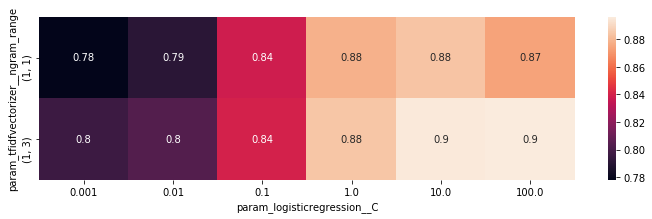

In [8]:
# extract scores from grid_search and visualize them for ranges of parametrs:
plt.figure().set_size_inches(12, 3)
h=G[["param_logisticregression__C", "param_tfidfvectorizer__ngram_range", "mean_test_score"]] .pivot_table(index="param_tfidfvectorizer__ngram_range", columns="param_logisticregression__C", values="mean_test_score")
sns.heatmap(h, annot=True)
plt.show()

In [9]:
# Classification report:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

report=classification_report(y_test[0:1000], grid1.predict(text_test[0:1000]))
print(report)

             precision    recall  f1-score   support

          0       0.90      0.91      0.91       498
          1       0.91      0.90      0.90       502

avg / total       0.91      0.91      0.90      1000



Confusion matrix, without normalization
[[455  43]
 [ 52 450]]
Normalized confusion matrix
[[0.91 0.09]
 [0.1  0.9 ]]


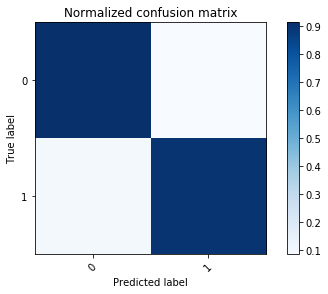

In [10]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test[0:1000], grid1.predict(text_test[0:1000]))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

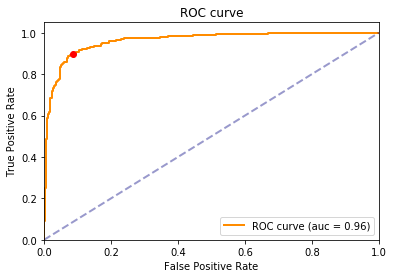

In [11]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test[0:1000]),grid1.predict_proba(text_test[0:1000])[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test[0:1000]), grid1.predict_proba(text_test[0:1000])[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

# Semantic analysis with tf-idf and n-grams techniques using LR model: 
    * Approach 2: with word normalization (i.e. using lammatization or stemming)

In [12]:
# run following script in the command line with admin privilage, to load the english package in spaCy:
# python -m spacy download en

In [13]:
# Technicality: we want to use the regexp-based tokenizer that is used by CountVectorizer 
# and only use the lemmatization from spacy. 
# We replace en_nlp.tokenizer (the spacy tokenizer) with the regexp-based tokenization:

from sklearn.feature_extraction.text import CountVectorizer
import re 

# regexp used in CountVectorizer 
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy language model and save old tokenizer 
en_nlp = spacy.load('en') 
old_tokenizer = en_nlp.tokenizer 

# replace the tokenizer with the preceding regexp 
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

# create a custom tokenizer using the spacy document processing pipeline (now using our own tokenizer) 
def custom_tokenizer(document):    
    doc_spacy = en_nlp(document)    
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer 
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, 
                             min_df=5, 
                             max_features=10000,
                             ngram_range=(1, 1)).fit(text_train)

In [14]:
# transform text_train using CountVectorizer with lemmatization 
X_train_lemma = lemma_vect.transform(text_train) 
X_test_lemma = lemma_vect.transform(text_test[0:2000]) 

print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

X_train_lemma.shape: (25000, 10000)


In [15]:
# We find the best logistic regression parameter using a grid search:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(TfidfTransformer(), 
                     LogisticRegression()) 

# running the grid search takes a long time because of the relatively large grid and the inclusion of trigrams 
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100]}

grid2 = GridSearchCV(pipe, param_grid, cv=2, n_jobs=-1) 
grid2.fit(X_train_lemma, y_train) 

G=pd.DataFrame(grid2.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
4,1.359863,0.054354,0.116190,0.000498,10,{'logisticregression__C': 10},0.87792,0.88072,0.87932,0.00140,1,0.97912,0.97880,0.97896,0.00016
3,0.800359,0.068317,0.120679,0.000997,1,{'logisticregression__C': 1},0.87672,0.87688,0.87680,0.00008,2,0.91936,0.92080,0.92008,0.00072
5,1.956763,0.088763,0.080786,0.006981,100,{'logisticregression__C': 100},0.86384,0.86688,0.86536,0.00152,3,1.00000,0.99952,0.99976,0.00024


In [16]:
print("Best parameters:\n{}".format(grid2.best_params_), '\n')
print("Best cross-validation score: {:.2f}".format(grid2.best_score_)) 
print("Test score: {:.2f}".format(grid2.score(X_test_lemma, y_test[0:2000])))

Best parameters:
{'logisticregression__C': 10} 

Best cross-validation score: 0.88
Test score: 0.88


In [19]:
# Classification report:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

report=classification_report(y_test[0:2000], grid2.predict(X_test_lemma), target_names=['spam', 'ham'])
print(report)

             precision    recall  f1-score   support

       spam       0.87      0.88      0.88       995
        ham       0.88      0.87      0.88      1005

avg / total       0.88      0.88      0.88      2000



Confusion matrix, without normalization
[[874 121]
 [126 879]]
Normalized confusion matrix
[[0.88 0.12]
 [0.13 0.87]]


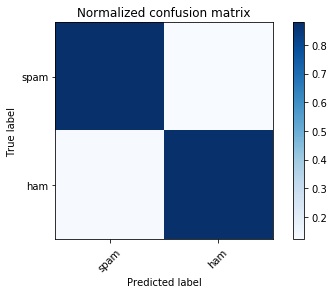

In [20]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["spam", "ham"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test[0:2000], grid2.predict(X_test_lemma))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

Most important features when using unigrams, bigrams, and trigrams with tf-idf rescaling


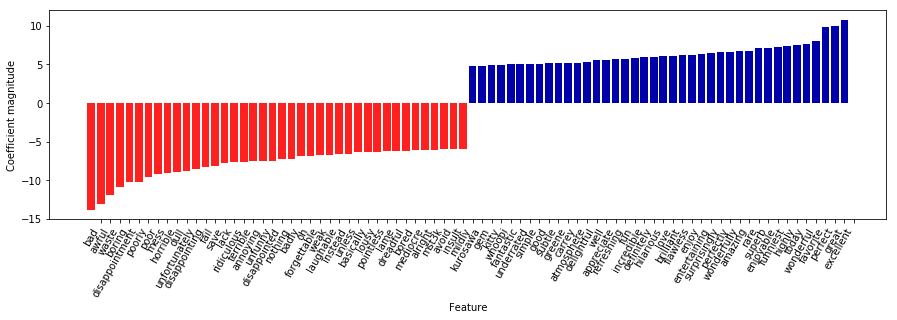

In [18]:
# Most important features when using unigrams, bigrams: 
feature_names = np.array(lemma_vect.get_feature_names()) 
coef = grid2.best_estimator_.named_steps['logisticregression'].coef_ 
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
print('Most important features when using unigrams, bigrams, and trigrams with tf-idf rescaling')